In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import ConfusionMatrixDisplay



from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor

import dtreeviz

from textwrap import wrap
from functools import reduce

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [80]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
701,1,NaN,59.33,6.522409,53.0,170.0,18.339100,126.0,83.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,5.152,5.083,10.235,2.0,1.0,7.20,6.75,13.95,0.0,0.0,0.0,6.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.84,14.9,44.2,2.966443,91.3,30.8,33.7,12.4,0.00,263.0,11.7,10.3,27.0,43.044190,0.039163,NaN,NaN,NaN,NaN,NaN,143.0,4.13,9.96,4.43,0.69,0.4,11.0,13.0,NaN,194.0,5.01684,0.0,97.0,2.50842,0.0,82.0,2.120520,0.0,75.0,0.84675,0.0,0.845361,0.773196,NaN,NaN,NaN,NaN,-0.111710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.10,NaN,NaN,NaN,NaN,NaN,NaN,2.33,5.43,18.08,7.0,13.0,6.2,22.7,3.661290,544.0,443.0,1.7,0.489914,0.073593,85.729411,NaN,NaN,201.0,42.0,23.1,7.18,33.93,NaN,NaN,4.23,NaN,NaN,NaN,0.401891,6.0,2.0,21.0
237,1,194.0,34.36,11.764706,46.0,158.0,18.426534,116.0,76.0,0.0,62.0,0.0,73.0,0.849315,0.0,1.0,0.392405,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.038,7.410,14.448,2.0,0.0,5.67,6.71,12.38,0.0,0.0,0.0,5.71,3.20,1.94,0.39,0.14,0.04,56.0,34.0,6.8,2.5,0.7,4.65,12.4,37.1,2.991935,79.8,26.7,33.4,14.3,0.00,260.0,14.0,11.6,37.4,45.534151,0.044615,134.020619,4.974359,1.649485,0.339755,0.024518,143.0,3.92,9.68,3.84,0.72,0.3,11.0,19.0,0.27,221.0,5.71506,1.0,71.0,1.83606,0.0,131.5,3.400590,0.0,94.0,1.06126,0.0,1.852113,1.323944,0.941780,28.202532,4.24504,4.515966,0.121870,353.0,44.0,396.0,11.0,10.0,89.0,93.0,3.34,23.68,0.733975,12.35,0.404345,0.0,0.0,1.74,4.26,17.90,6.0,10.0,6.6,5.0,0.75757

<Axes: >

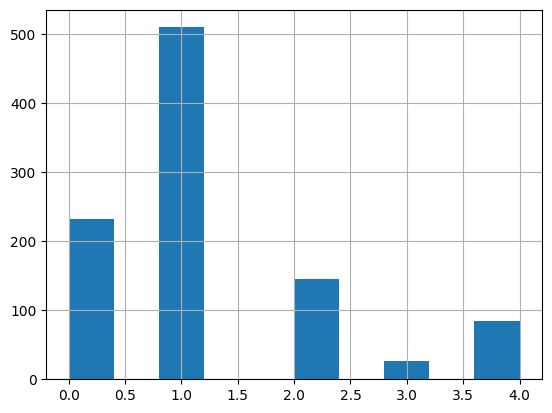

In [81]:
df[PCO].hist()

# Model selection for PCO

### Remove the `POF` class

In [82]:
# df[df[PCO] == 3][PCO]
df.loc[df[PCO] == 3, PCO] = np.nan

#  change all 4s to 3s for the need of the visualisation algorithm
df[PCO] = np.where(df[PCO] == 4, 3, df[PCO])

In [83]:
df_cleaned = df.dropna(subset=[PCO])

X, y = df_cleaned.drop(columns=[PCO]), df_cleaned[PCO]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
CLASS_NAMES = ['healthy', 'PCOS', 'FHA', 'High Andro']

In [85]:
def get_categorical_attributes_except(attribute):
    remaining_attributes = CATEGORICAL_ATTRIBUTES.copy()
    remaining_attributes.remove(attribute)
    return remaining_attributes


def plot_confussion_matrices(model, X_train, y_train, X_test, y_test):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    #  TODO: change into CLASS_NAMES
    display_labels = ['healthy', 'PCOS', 'FHA', 'High Andro']

    ConfusionMatrixDisplay.from_estimator(
        model,
        X_train,
        y_train,
        display_labels=display_labels,
        cmap=plt.cm.Blues,
        ax=axs[0],
    )
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=display_labels,
        cmap=plt.cm.Blues,
        ax=axs[1],
    )

    axs[0].set_title('Training Set')
    axs[1].set_title('Test Set')
    plt.tight_layout()
    plt.show()

In [86]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])


preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])

In [109]:
model = DecisionTreeClassifier()

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

param_grid = {
    'model__max_depth': [3, 4, 5, 7, 9, 12],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', None]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score (f1_weighted):", best_score)

Best parameters: {'model__class_weight': None, 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
Best score (f1_weighted): 0.736292054817271


Not balanced
F1 Scores: [0.75851426 0.73212494 0.72404687 0.7253572  0.76647734 0.69018314
 0.76612538 0.74403181 0.70841317 0.73530162 0.72001816 0.73804945
 0.74321216 0.75013194 0.7423934 ], 
Mean F1: 0.736292054817271


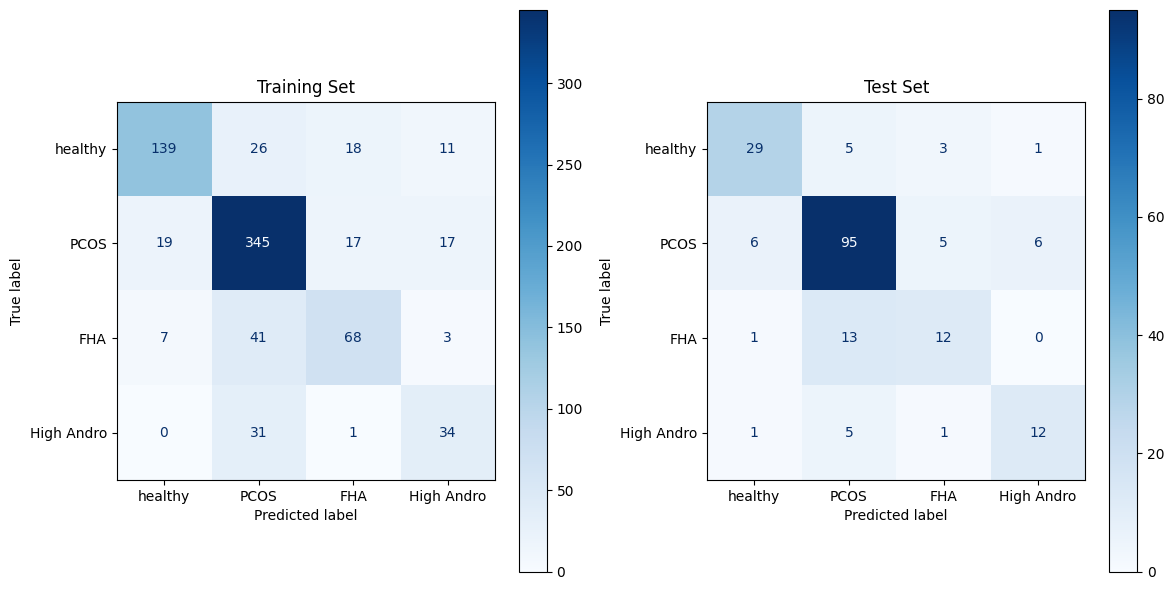

In [102]:
def validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test):
    # pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    print(f'F1 Scores: {scores}, \nMean F1: {scores.mean()}')

    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)

    plot_confussion_matrices(pipeline, X_train, y_train, X_test, y_test)



continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])


print('Not balanced')
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight=None)
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

#### Balanced

F1 Scores: [0.74485283 0.76099339 0.71500126 0.72967718 0.74945908 0.73525168
 0.75782815 0.73779784 0.68071017 0.72467532 0.72830237 0.70531558
 0.7534498  0.74299615 0.73120646], 
Mean F1: 0.7331678187251502


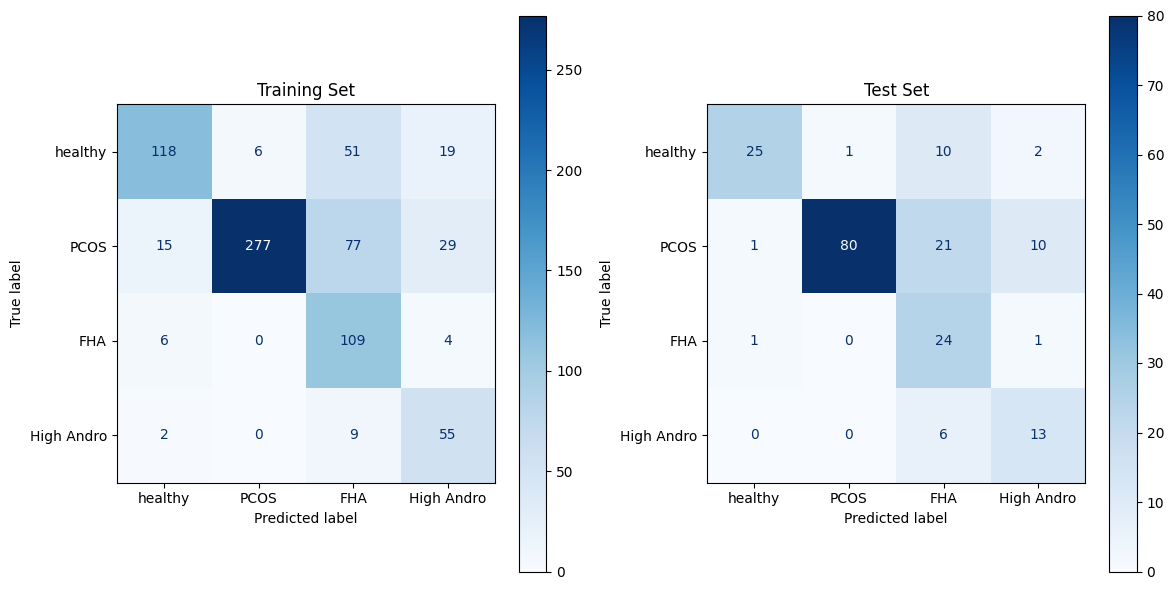

In [101]:
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight='balanced')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

F1 Scores: [0.69558537 0.64734085 0.63151441 0.63634765 0.7110475  0.65301517
 0.67848605 0.61612657 0.58674638 0.61960512 0.66471048 0.64659646
 0.6519676  0.67110714 0.61844587], 
Mean F1: 0.648576174833835


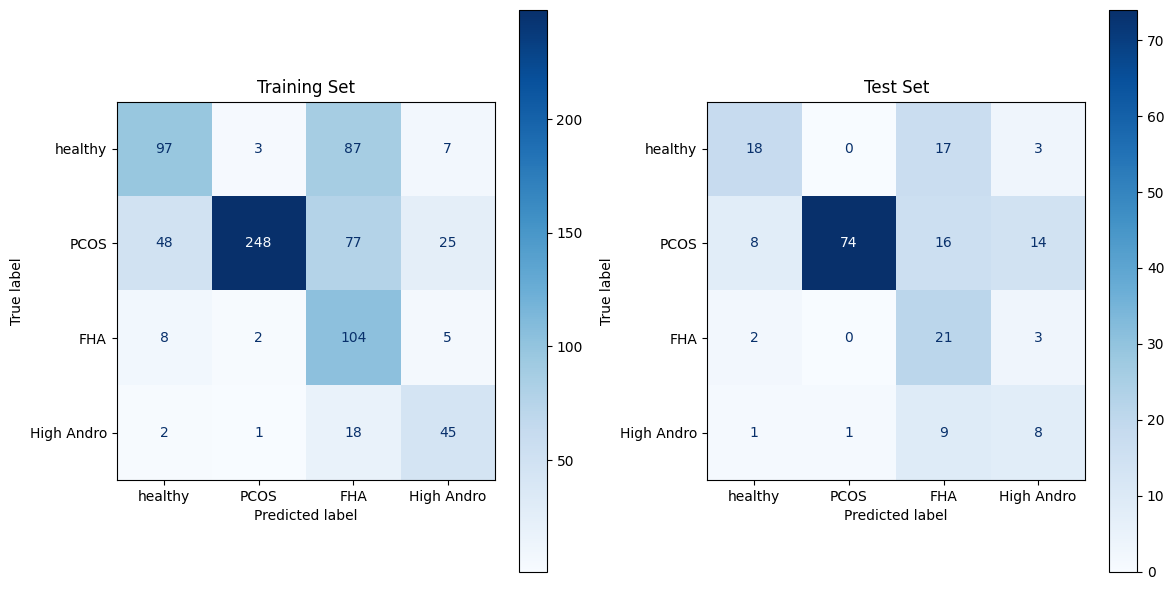

In [88]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])
# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])
#  NOTE: Drzewo działa dużo lepiej kiedy nie zastępujemy brakujących wartości

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight='balanced')


pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

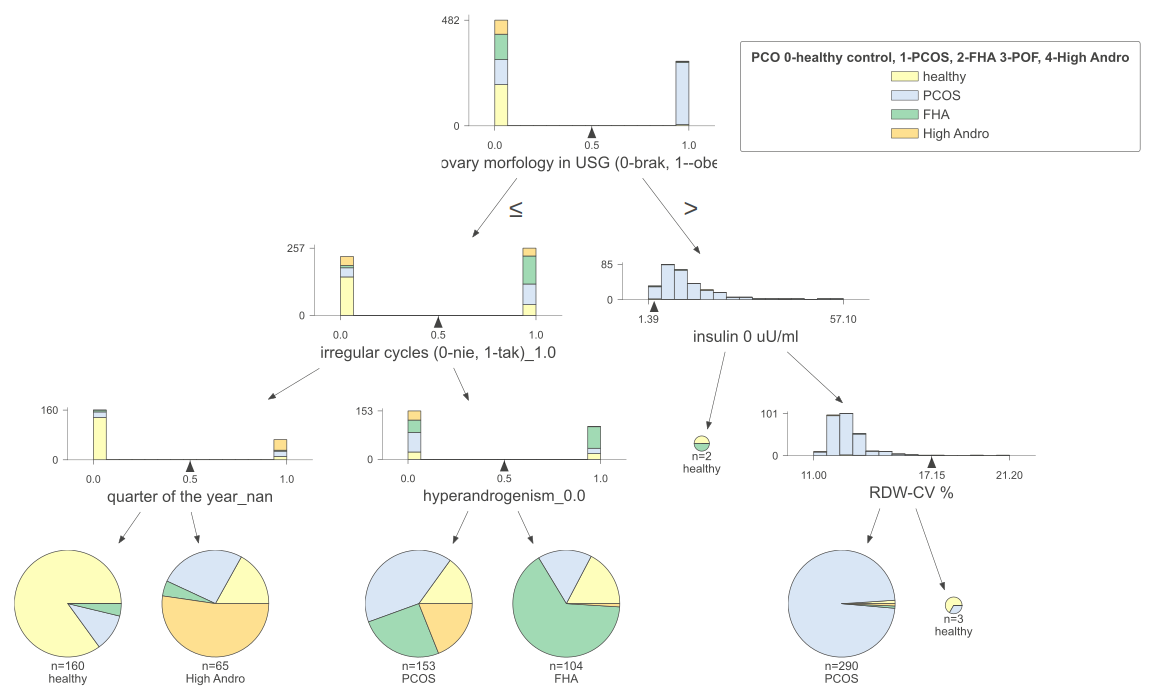

In [98]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight=None)

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

pipeline.fit(X_train, y_train)
X_transformed = preprocessor.fit_transform(X_train, y_train)
column_names = pipeline['preprocessor'].get_feature_names_out()


viz_model = dtreeviz.model(model,
                           X_train=X_transformed, y_train=y_train.astype(int),
                           feature_names=column_names,
                           target_name=PCO,
                           class_names=CLASS_NAMES,
                           )

viz_model.view(scale=1.8)

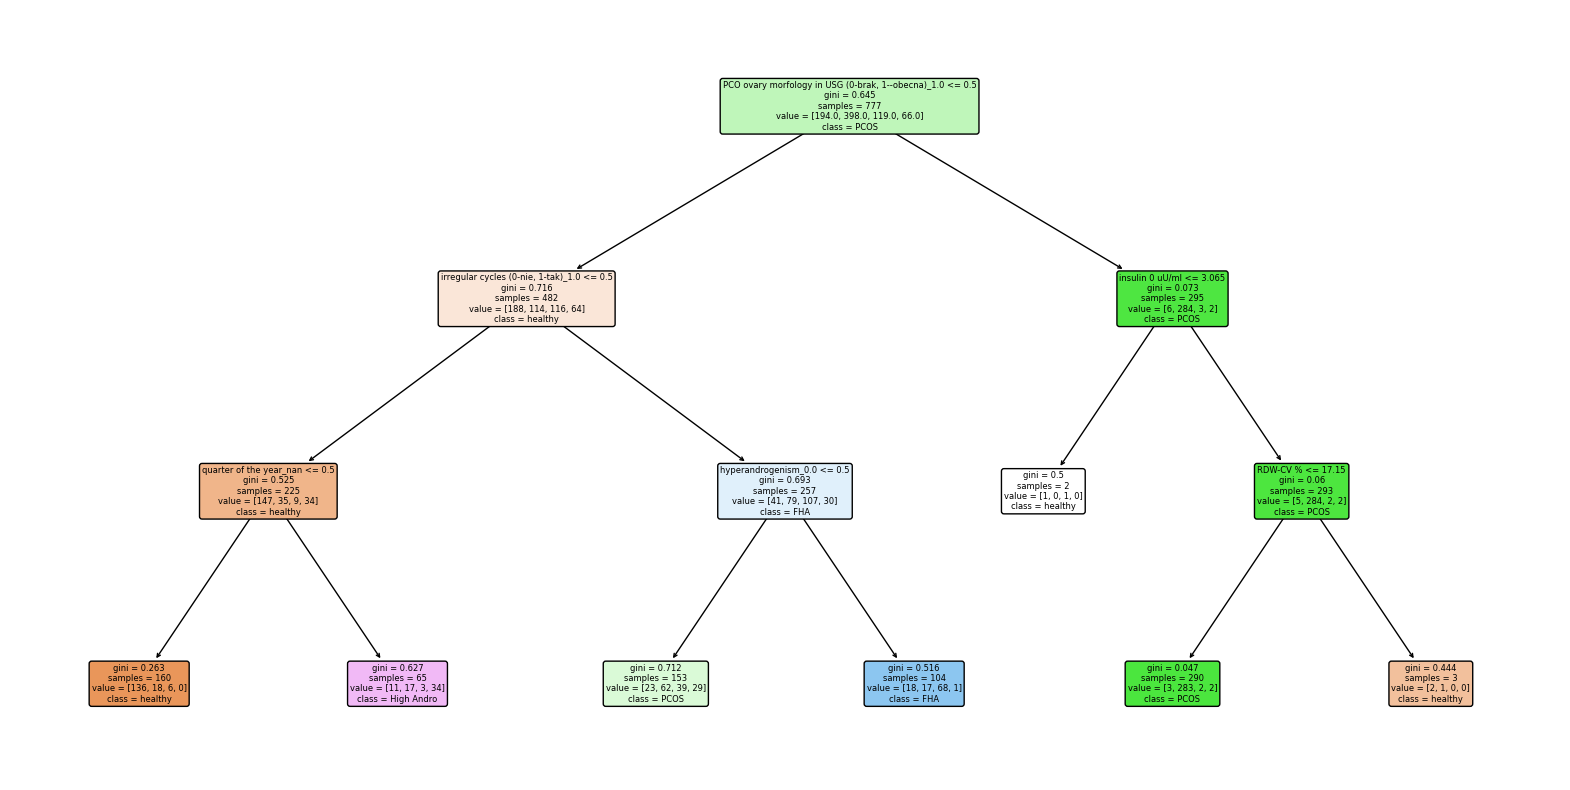

In [99]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

## Feature importances


## Feature selection methods

In [93]:
selector = VarianceThreshold(threshold=0.001)
selector.set_output(transform='pandas')
selector.fit_transform(X_train)

kept_features_mask = selector.get_support()

print("Usunięte cechy:", [X_train.columns[i] for i, keep in enumerate(kept_features_mask) if not keep])

Usunięte cechy: ['basophils x10^3/ul', 'NRBC x10^3/ul', 'MPV/PLT', 'eos/leukocyty', 'Testosterone/DHT']


### SelectKBest

In [94]:

from sklearn.feature_selection import f_classif


def feature_selection(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
            ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]
    print(selected_feature_names)

    return pd.DataFrame(X_new, columns=selected_feature_names)


feature_selection(SelectKBest(f_classif, k=10), X_train, y_train).head()

['ovaries volume - total', 'irregular cycles (0-nie, 1-tak)_1.0', 'ovulation (0-brak, 1-obecna)_0.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_0.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_nan', 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan', 'chronic thyroiditis_nan', 'follicules >12_1.0', 'quarter of the year_nan']


,ovaries volume - total,"irregular cycles (0-nie, 1-tak)_1.0","ovulation (0-brak, 1-obecna)_0.0","PCO ovary morfology in USG (0-brak, 1--obecna)_0.0","PCO ovary morfology in USG (0-brak, 1--obecna)_1.0","PCO ovary morfology in USG (0-brak, 1--obecna)_nan","nodules 0-lack, 1-RL, 2-LL, 3-both_nan",chronic thyroiditis_nan,follicules >12_1.0,quarter of the year_nan
0,9.666800,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,18.290000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8.150000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17.371722,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.980000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Recursive feature elimination

Optimal number of features: 3
['irregular cycles (0-nie, 1-tak)_1.0'
 'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0'
 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan']


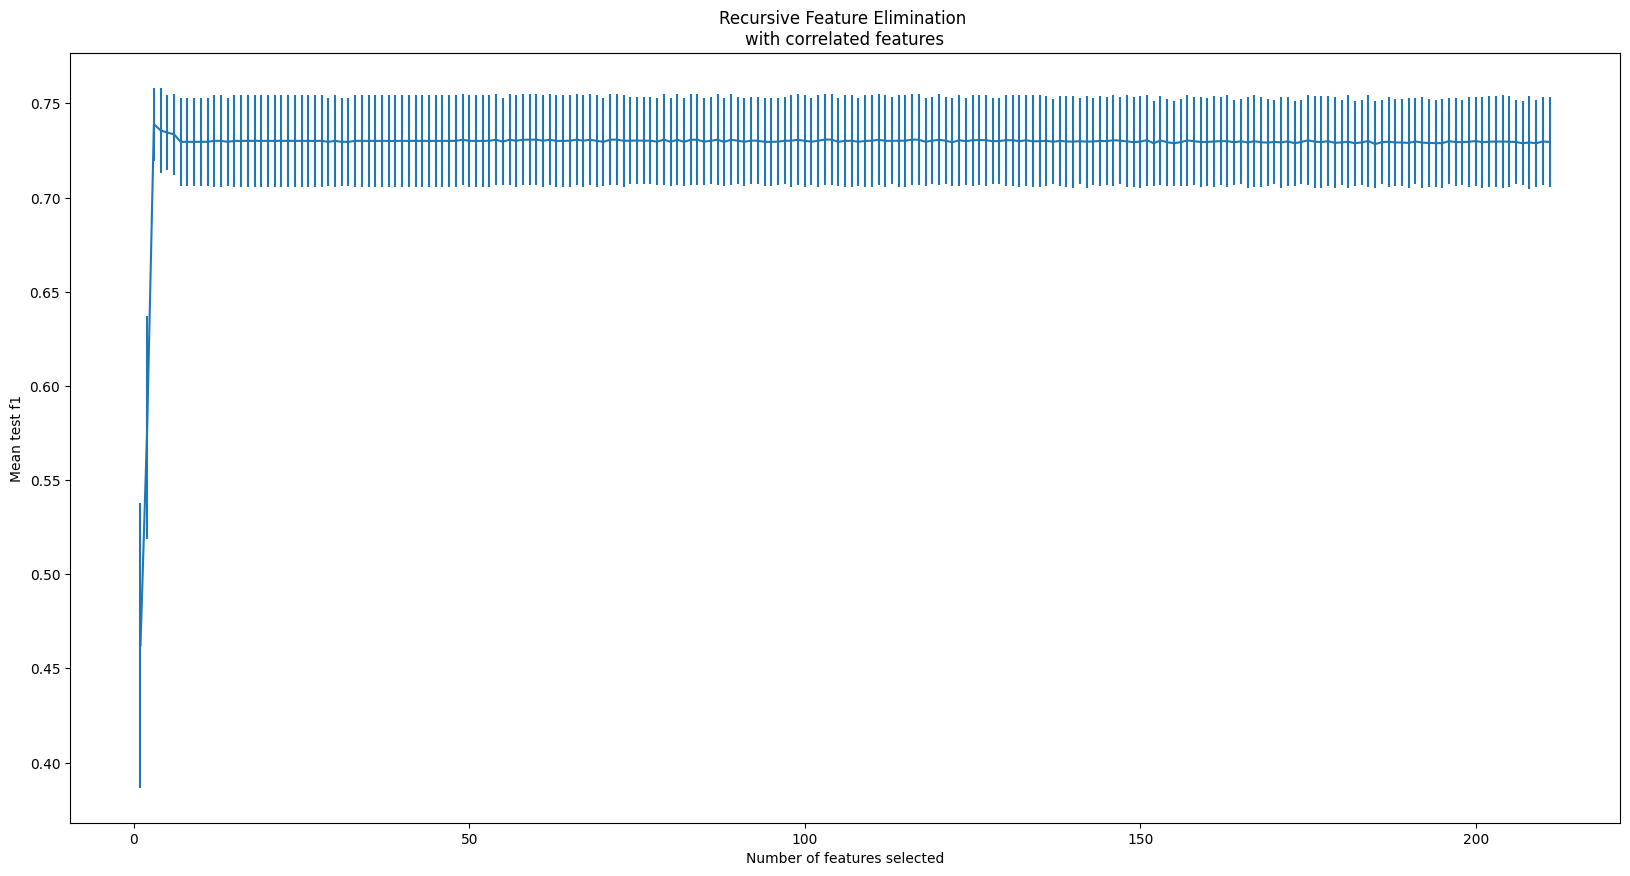

In [95]:
min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="f1_weighted",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train, y_train)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

# print(len(preprocessor.get_feature_names_out()))
print(f"Optimal number of features: {rfecv.n_features_}")
# print(rfecv.get_feature_names_out())
print(selected_feature_names)

n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test f1")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### SelectFromModel

In [96]:
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
sel_from_model = SelectFromModel(
    estimator=model,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('sel_from_model', sel_from_model)])
pipeline.fit(X_train, y_train)

selected_feature_indices = sel_from_model.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
selected_feature_names

array(['weight', 'height (cm)', 'FTI (free testosterone index)',
       'irregular cycles (0-nie, 1-tak)_1.0',
       'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0',
       'hypothyroidism_nan', 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan'],
      dtype=object)

### Permutation importance

In [97]:
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

result = permutation_importance(pipeline, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_weighted')
importances = result.importances_mean

feature_importances = dict(zip(preprocessor.get_feature_names_out(), importances))

sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

df_importances = pd.DataFrame(sorted_importances, columns=['feature', 'importance'])

df_importances.head(15)

,feature,importance
0,neutrophil x10^3/ul,0.294271
1,ovaries volume - total,0.117194
2,RBC x10^6ul,0.067505
3,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_0.0",0.017257
4,weight,0.005064
5,% lymphocytes,0.003560
6,WC>88_nan,0.002171
7,height (cm),0.001458
8,Hypertension_0.0,0.000490
9,Bilirubin mg/dl,0.000179


## Test

In [99]:
# feature_subset = ['weight', 'height (cm)', 'FTI (free testosterone index)',
#        'irregular cycles (0-nie, 1-tak)',
#        'PCO ovary morfology in USG (0-brak, 1--obecna)',
#        'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both']

# preprocessor = ColumnTransformer(
#        verbose_feature_names_out=False,
#        transformers=[
#        ('num', continuous_preprocessor, ['weight', 'height (cm)', 'FTI (free testosterone index)', ]),
#        ('cat', categorical_preprocessor, ['irregular cycles (0-nie, 1-tak)',
#                                           'PCO ovary morfology in USG (0-brak, 1--obecna)',
#                                           'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both'])
#        ])


feature_subset = [
#     'weight', 'height (cm)', 'FTI (free testosterone index)',
       'irregular cycles (0-nie, 1-tak)',
       'PCO ovary morfology in USG (0-brak, 1--obecna)',
       'nodules 0-lack, 1-RL,  2-LL, 3-both']
preprocessor = ColumnTransformer(
       verbose_feature_names_out=False,
       transformers=[
       # ('num', continuous_preprocessor, ['weight', 'height (cm)', 'FTI (free testosterone index)', ]),
       ('cat', categorical_preprocessor, ['irregular cycles (0-nie, 1-tak)',
                                          'PCO ovary morfology in USG (0-brak, 1--obecna)',
                                          'nodules 0-lack, 1-RL,  2-LL, 3-both'])
       ])

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=2, class_weight='balanced')

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train[feature_subset], y_train)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(pipeline, X_train[feature_subset], y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
scores.mean()


0.7271373628553927

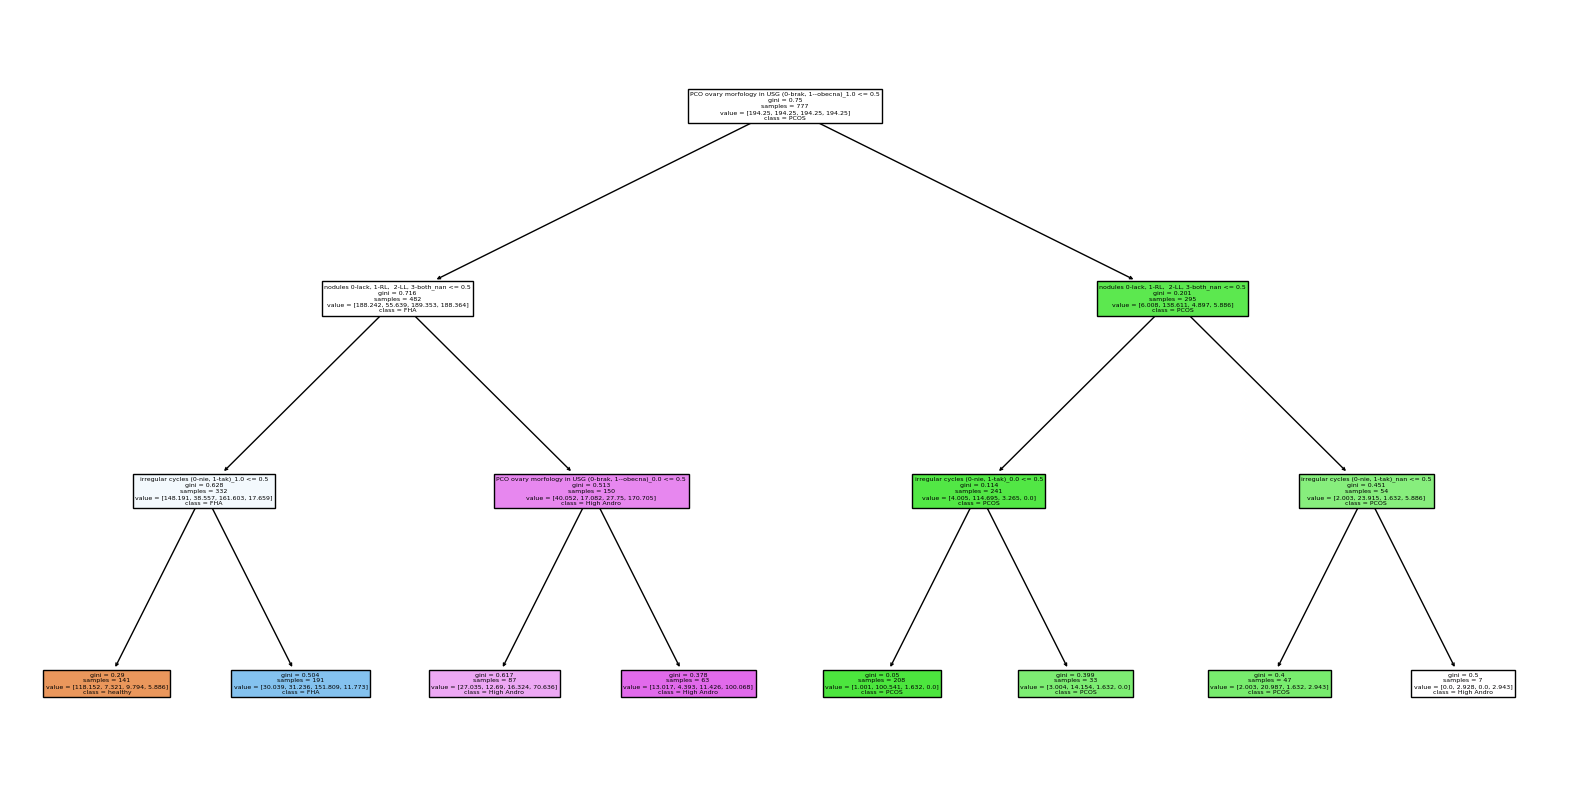

In [100]:
plt.figure(figsize=(20,10))
column_names = pipeline['preprocessor'].get_feature_names_out()
plot_tree(model, filled=True, feature_names=column_names, class_names=['healthy', 'PCOS', 'FHA', 'High Andro'])
plt.savefig('charts/trees/PCO_amall_tree.pdf')
plt.show()

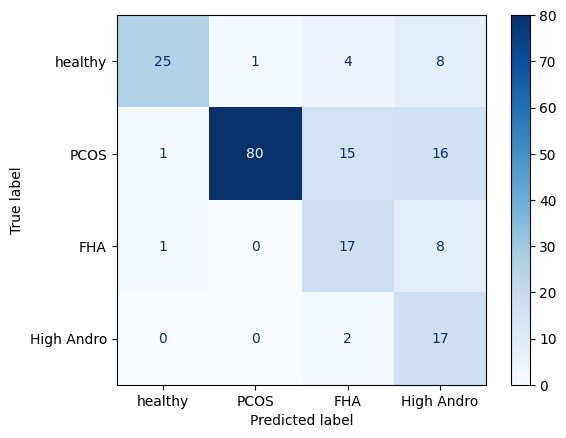

In [101]:

disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_test,
        y_test,
        display_labels=['healthy', 'PCOS', 'FHA', 'High Andro'],
        cmap=plt.cm.Blues,
    )

## TPOT

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='r2', n_jobs=-1)
tpot.fit(X_train, y_train)

print(tpot.fitted_pipeline_)

print("Score on test set:", tpot.score(X_test, y_test))

tpot.export('tpot_pipeline.py')

In [ ]:

cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='neg_mean_absolute_error', n_jobs=-1)
tpot.fit(X_train, y_train)

# Wyświetlenie najlepszego znalezionego rurociągu
print(tpot.fitted_pipeline_)

# Ocena modelu na zbiorze testowym
print("Score on test set:", tpot.score(X_test, y_test))

# Eksportowanie optymalnego rurociągu do pliku Pythona
tpot.export('tpot_pipeline.py')

Imputing missing values in feature set
                                                                              
Generation 1 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 2 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 3 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 4 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 5 - Current best internal CV score: -8.435646067190696
                                                           
Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimat